In [2]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *


from subprocess import check_output
print(check_output(["ls", "Data"]).decode("utf8"))

Using TensorFlow backend.


Split_Data
category_names.7z
category_names.csv
data.pkl
sample
sample_submission.7z
sample_submission.csv
test.bson
train.bson
train_example.bson



In [8]:
keras.__version__, tf.__version__

('2.2.4', '1.13.1')

In [9]:
data_dir = "Data/"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

Part 1 Creating Lookup Tables

In [10]:
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


Create dictionaries for quick lookup of category_id to category_idx mapping.

In [11]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [12]:
cat2idx, idx2cat = make_category_tables()

In [13]:
# Test if it works:
cat2idx[1000012755], idx2cat[4]

(4, 1000012755)

Read bson files

In [9]:
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON.decode(item_data)
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [10]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

100%|██████████| 7069896/7069896 [22:36<00:00, 5211.03it/s]  


CPU times: user 1min 1s, sys: 35.2 s, total: 1min 36s
Wall time: 22min 44s


In [11]:
train_offsets_df[train_offsets_df['num_imgs']>2].head()

,num_imgs,offset,length,category_id
product_id,,,,
13,4,71824,15914,1000010961
25,4,136350,17796,1000010653
26,4,154146,13648,1000001859
43,3,265312,9591,1000004079
57,3,350762,13204,1000003787


In [12]:
train_offsets_df.to_csv("train_offsets.csv")

In [13]:
# How many products?
len(train_offsets_df)

7069896

In [14]:
# How many categories?
len(train_offsets_df["category_id"].unique())

5270

In [15]:
# How many images in total?
train_offsets_df["num_imgs"].sum()

12371293

Create a random train.validation split

In [16]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.0001):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

In [17]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.25, 
                                              drop_percentage=0.0)

7069896it [00:06, 1144102.35it/s]
100%|██████████| 7069896/7069896 [03:19<00:00, 35477.43it/s]


In [18]:
train_images_df[train_images_df['img_idx']>2].head()

,product_id,category_idx,img_idx
6,25,5055,3
44,152,5055,3
106,381,5055,3
127,449,5055,3
138,493,5055,3


In [19]:
# val_images_df[val_images_df['img_idx']>1].head()
val_images_df.head()

,product_id,category_idx,img_idx
0,0,5055,0
1,1,5055,0
2,11,5055,0
3,40,5055,0
4,44,5055,0


In [20]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

Number of training images: 9281798
Number of validation images: 3089495
Total images: 12371293


In [21]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())

(5270, 5270)

In [22]:
category_idx = 619
num_train = np.sum(train_images_df["category_idx"] == category_idx)
num_val = np.sum(val_images_df["category_idx"] == category_idx)
num_val / num_train

0.3109792284866469

In [23]:
train_images_df.to_csv("train_images.csv")
val_images_df.to_csv("val_images.csv")

Part 2 : The genrator

In [5]:
categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images.csv", index_col=0)
val_images_df = pd.read_csv("val_images.csv", index_col=0)

/Users/anilkumar/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [14]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)

            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        return self._get_batches_of_transformed_samples(index_array)

In [15]:
train_bson_file = open(train_bson_path, "rb")

In [16]:
import threading
lock = threading.Lock()

In [17]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock,
                       batch_size=batch_size, shuffle=True)

Found 9281798 images belonging to 5270 classes.
Found 3089495 images belonging to 5270 classes.


In [18]:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

CPU times: user 118 ms, sys: 30.5 ms, total: 149 ms
Wall time: 2.11 s


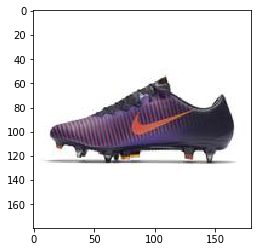

In [19]:
plt.imshow(bx[-1].astype(np.uint8))

In [20]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                     SPORT
category_level2                  FOOTBALL
category_level3    CHAUSSURES DE FOOTBALL
category_idx                         4605
Name: 1000018826, dtype: object

In [21]:
%time bx, by = next(val_gen)

CPU times: user 223 ms, sys: 53.9 ms, total: 277 ms
Wall time: 2.23 s


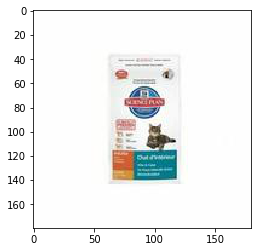

In [22]:
plt.imshow(bx[-1].astype(np.uint8))

In [23]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                      ANIMALERIE
category_level2                    ALIMENTATION
category_level3    CROQUETTE - NOURRITURE SECHE
category_idx                                 25
Name: 1000016234, dtype: object

Part 3: Training

In [24]:
# from keras.models import Sequential
# from keras.layers import Dropout, Flatten, Dense
# from keras.layers.convolutional import Conv2D
# from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
# from keras import optimizers

# model = Sequential()
# model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.3))
# model.add(Conv2D(64, 3, padding="same", activation="relu"))
# model.add(MaxPooling2D())
# model.add(Dropout(0.3))
# model.add(Conv2D(128, 3, padding="same", activation="relu"))
# model.add(MaxPooling2D())
# model.add(Dropout(0.2))
# # model.add(Flatten())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(num_classes, activation="softmax"))
# adamOpt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
# model.compile(optimizer=adamOpt,
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])

# model.summary()


from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
model.add(Dropout(0.3))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation="softmax"))

adamOpt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(optimizer=adamOpt, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxP

In [ ]:
# To train the model:
model.fit_generator(train_gen,
                    steps_per_epoch = 10,   #num_train_images // batch_size,
                    epochs = 3,
                    validation_data = val_gen,
                    validation_steps = 10,  #num_val_images // batch_size,
                    workers = 8)


# model.fit_generator(train_gen,
#                     steps_per_epoch = 10,   #num_train_images // batch_size,
#                     epochs = 3,
#                     validation_data = val_gen,
#                     validation_steps = 10,  #num_val_images // batch_size,
#                     workers = 8)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3


In [59]:
# To evaluate on the validation set:
#model.evaluate_generator(val_gen, steps=num_val_images // batch_size, workers=8)


Part 4: Test set split

In [46]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

submission_df = pd.read_csv(data_dir + "sample_submission.csv")
submission_df.head()


test_datagen = ImageDataGenerator()
data = bson.decode_file_iter(open(test_bson_path, "rb"))

with tqdm(total=num_test_products) as pbar:
    for c, d in enumerate(data):
        product_id = d["_id"]
        num_imgs = len(d["imgs"])

        batch_x = np.zeros((num_imgs, 180, 180, 3), dtype=K.floatx())

        for i in range(num_imgs):
            bson_img = d["imgs"][i]["picture"]

            # Load and preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=(180, 180))
            x = img_to_array(img)
            x = test_datagen.random_transform(x)
            x = test_datagen.standardize(x)

            # Add the image to the batch.
            batch_x[i] = x

        prediction = model.predict(batch_x, batch_size=num_imgs)
        avg_pred = prediction.mean(axis=0)
        cat_idx = np.argmax(avg_pred)

        submission_df.iloc[c]["category_id"] = idx2cat[cat_idx]        
        pbar.update()

# submission_df.to_csv("my_submission.csv.gz", compression="gzip", index=False)
submission_df.to_csv("my_submission.csv")

100%|██████████| 1768182/1768182 [12:01:17<00:00, 40.86it/s]  
